In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataPath = "Data3rdOctave.txt"
data = pd.read_csv(dataPath, sep="\t")
data.head()

,Temperature,Pressure,Frequency,Sound Pressure Level
0,63.9138,0.0222,500,22.8779
1,63.9138,0.0222,630,22.1560
2,63.9138,0.0222,800,22.2277
3,63.9138,0.0222,1000,21.9869
4,63.9138,0.0222,1250,21.9085


Text(0.5,1,'First Data Point not Viable')

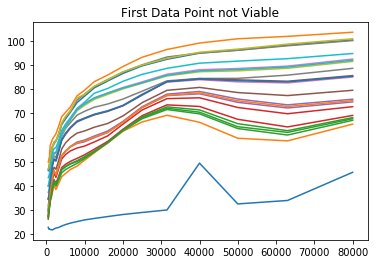

In [3]:
data2 = np.array(data)

for n in range(0,23**2, 23):
    x = data2[n:n+23,2]
    y = data2[n:n+23,3]
    plt.plot(x,y)

plt.title("First Data Point not Viable")


In [4]:
# removes first row as it does not conform to other data
data2 = data2[23:]
data2.shape

(506, 4)

Text(0.5,1,'Cleaned Up Data')

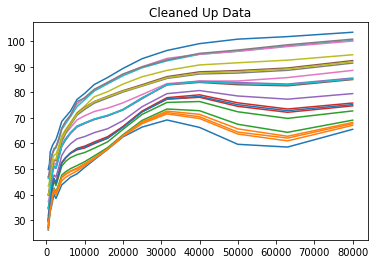

In [5]:

for n in range(0,23**2, 23):
    x = data2[n:n+23,2]
    y = data2[n:n+23,3]
    plt.plot(x,y)    

plt.title("Cleaned Up Data")

## Scaling the Data

Because the temperature and pressure variables in our dataset is continuous, we will scale these to have a mean of 0 and a standard deviation of 1. This will make it easier on the computer to perform calculations. The scaling factors are saved so we can revert back to the original values later.



In [6]:
# Turns frequency into binary categories
#dummy = pd.get_dummies(data["Frequency"], drop_first = False)
#f = data.copy
#f = pd.concat([data, dummy], axis = 1)
#f = f.drop("Frequency", axis = 1)
#f = f.drop(list(range(23)), axis = 0)

# Now move labels to the first column:
#cols = f.columns
#newcols = []
#for col in cols:
#    if col == "Temperature":
#        newcols.append("Sound Pressure Level")
#    elif col == "Sound Pressure Level":
#        newcols.append("Temperature")
#    else:
#        newcols.append(col)
#f = f.reindex(columns = newcols)
#f.head()


In [7]:

features = data.columns
features_index = range(len(features))
scaling_factors = {} # stores mean and std of each feature
scaled_data = []

for index in features_index:
    feature = data2[:, index]
    mean = np.mean(feature)
    std = np.std(feature)
    scaling_factors[features[index]] = [mean, std]
    
    data2[:,index] = (data2[:, index] - mean)/std
    
print("Data is scaled and normalized")
print(data2[0])

Data is scaled and normalized
[-0.80151276 -0.9191696  -0.75115043 -1.92733662]


## Split Data into Training, Testing and Validation Sets

We'll use 80% of the data to train, 10% for testing, and 10% for validation.

In [8]:
#np.random.shuffle(data2)

train_index = int(len(data2)*0.8)
test_index = int(len(data2)*0.9)
val_index = len(data2)

train_features, train_targets = data2[:train_index, :3], data2[:train_index, 3]
test_features, test_targets = data2[train_index:test_index, :3], data2[train_index:test_index, 3]
val_features, val_targets = data2[test_index:val_index, :3], data2[test_index:val_index, 3]

print("Testing, Training, and Validation sets created!")

Testing, Training, and Validation sets created!


## Building the Nueral Network

Our network will be comprised of two layers, a hidden layer, and an output layers. We'll use a sigmoid function for activations in the hidden layer. 


In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        
        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes))
        
        
        def sigmoid(x): return 1/(1+np.exp(-x))
        self.sigmoid = sigmoid
    
    def train(self, features, targets):
        
        n_records = features.shape[0]
        delta_weights_i2h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h2o = np.zeros(self.weights_hidden_to_output.shape)
        
        for x, y in zip(features, targets):
            
            ## Forward Pass:
            hidden_inputs = np.dot(x, self.weights_input_to_hidden)
            hidden_outputs = self.sigmoid(hidden_inputs)
            
            # Output layer:
            final_outputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
            
            ## Backward Pass:
            
            # Output Error:
            output_error_term = y - final_outputs
            
            # Hidden Lyaer's contribution to error:
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            
            # Calculate Delta Weights:
            delta_weights_i2h += hidden_error_term * x[:,None]
            delta_weights_h2o += output_error_term * hidden_outputs[:,None]
            
        # Update Weights:
        self.weights_input_to_hidden += self.lr * delta_weights_i2h /n_records
        self.weights_hidden_to_output += self.lr * delta_weights_h2o / n_records
            
        
    def run(self, features):
        # Runs a single forward pass:
        
        # Hidden Layer:
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.sigmoid(hidden_inputs)
        
        # Output Layer:
        final_outputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        
        return final_outputs
       
        
        

In [10]:
def MSE(y, Y):
    return (np.mean((y-Y)**2))

## Train the Network:

Here, we'll actually train the network by running our NeuralNetwork class numerous times.

In [34]:
import sys

# Hyperparatmeters:
epochs = 1000
learning_rate = 0.001
hidden_nodes = 2
output_nodes = 1

# Create Network
input_nodes = train_features.shape[1]
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# Intialize losses:
losses = {"train": [], "validation":[]}

# Early Stopping var:
eStop = 0

for i in range(epochs):
    
    #if i % 100 == 0:
        #learning_rate *= 0.8
        
    # Randomly choose batches of 128 from training data set:
    batch = np.random.choice(train_features.shape[0], size = 16)
    x, y = train_features[batch], train_targets[batch]
    
    network.train(x,y)
    
    # Print out training progress:
    train_loss = MSE(network.run(train_features), train_targets)
    val_loss = MSE(network.run(val_features), val_targets)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * i/float(epochs)) \
                     + "% ... Training loss: " + str(train_loss) \
                     + " ... Validation loss: " + str(val_loss))
    sys.stdout.flush()
    
    losses["train"].append(train_loss)
    losses["validation"].append(val_loss)
    
    # Implement Early Stopping:
    maxloss = max(losses["train"])   
    if(i > 100 and train_loss >= maxloss):
        eStop += 1
    else:
        eStop = 0
    
    if eStop == 15:
        print()
        print("Early stopped at epoch: " + str(i))
        break
    

Progress: 99.9% ... Training loss: 1.2468472775013213 ... Validation loss: 1.2437053261427284

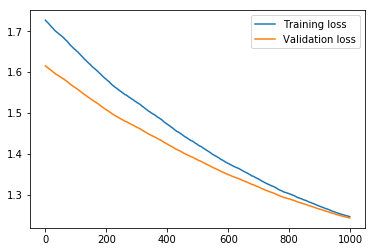

In [35]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Checking Predictions vs. Reality:

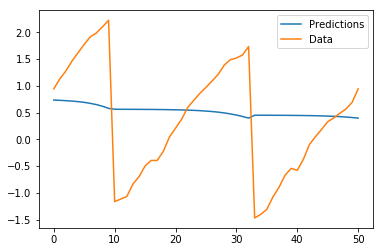

In [51]:
mean, std = scaling_factors["Sound Pressure Level"]
predictions = network.run(test_features)



#predictions = predictions*std + mean
#test_targets2 = test_targets*std + mean


plt.plot(predictions, label = "Predictions")
plt.plot(test_targets, label = "Data")
plt.legend()


In [55]:
print(max(predictions) - min(predictions))
#print(max(test_targets2) - min(test_targets2))
print()
x = predictions
print(x)

print(train_targets.mean())

[0.33674318]

[[0.73324379]
 [0.72862578]
 [0.72198338]
 [0.71414755]
 [0.70400498]
 [0.69028871]
 [0.6715697 ]
 [0.64867706]
 [0.61813247]
 [0.57831444]
 [0.56124021]
 [0.56096741]
 [0.56061043]
 [0.56019007]
 [0.55966408]
 [0.55892668]
 [0.55808249]
 [0.55702512]
 [0.55564709]
 [0.5538393 ]
 [0.55170445]
 [0.54891673]
 [0.5452514 ]
 [0.54091288]
 [0.53545431]
 [0.52775777]
 [0.51890493]
 [0.50779414]
 [0.49336013]
 [0.4746861 ]
 [0.45332761]
 [0.42712672]
 [0.39650061]
 [0.45052314]
 [0.45023441]
 [0.44985679]
 [0.44941246]
 [0.44885694]
 [0.44807901]
 [0.44718969]
 [0.4460777 ]
 [0.44463163]
 [0.44273998]
 [0.44051391]
 [0.43761975]
 [0.43383611]
 [0.42938896]
 [0.42384146]
 [0.41610845]
 [0.40733986]
 [0.39652162]]
-0.012547455011866313


In [53]:
print(train_features.shape)

(404, 3)
